In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'scripts'))  # nopep8


from close_loop_anesth.loop import perform_simulation
# from close_loop_anesth.experiments import auto_tune_pid
from create_param import load_mekf_param, load_mhe_param
from close_loop_anesth.utils import custom_disturbance


/home/aubouinb/ownCloud/Code/TIVA_Drug_Control/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NMPC_param = {'N': 60, 'Nu': 60, 'R': 0.1*np.diag([4, 1])}
NMPC_param['bool_non_linear'] = True
NMPC_param['R_maintenance'] = NMPC_param['R'] * 10
NMPC_param['terminal_cost_factor'] = 20

mekf_param = load_mekf_param([5, 6, 6],
                             q=10,
                             r=1,
                             alpha=10,
                             lambda_2=1e-2,
                             epsilon=0.8)

mhe_param = load_mhe_param(R=0.1, N_mhe=30, vmax=1e4, q=1e3, vmin=0.1)

# rename dict keys
mekf_param['R_mekf'] = mekf_param.pop('R')
mekf_param['Q_mekf'] = mekf_param.pop('Q')
mekf_param['P0_mekf'] = mekf_param.pop('P0')

# mhe_param['R_mhe'] = mhe_param.pop('R')
# mhe_param['Q_mhe'] = mhe_param.pop('Q')
# mhe_param['P_mhe'] = mhe_param.pop('P')

# merge the two dicts
estimate_param = {**mekf_param, **mhe_param}
estimate_param['switch_time'] = 180




age = 27
height = 165
weight = 70
gender = 0

pid_param = {'ratio': 2, 'auto_tune': True, 'cost_choice': 'IAE_biased_normal'}

In [3]:
start_time = time.time()


results = perform_simulation([age, height, weight, gender],
                             'total',
                             'MHE_NMPC',
                             NMPC_param,
                             mhe_param,
                             [True, True],
                             2,
                             bool_noise=False)

print(f"Simulation time: {time.time() - start_time:.2f} s")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Simulation time: 84.27 s


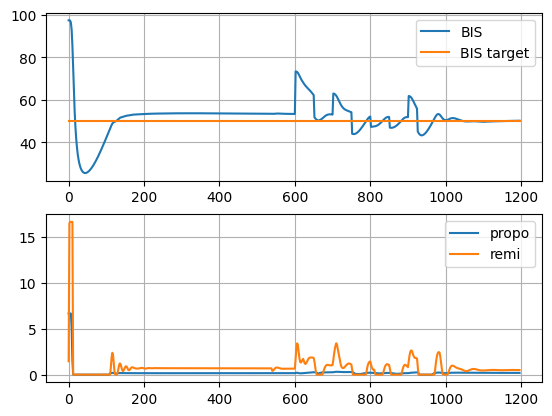

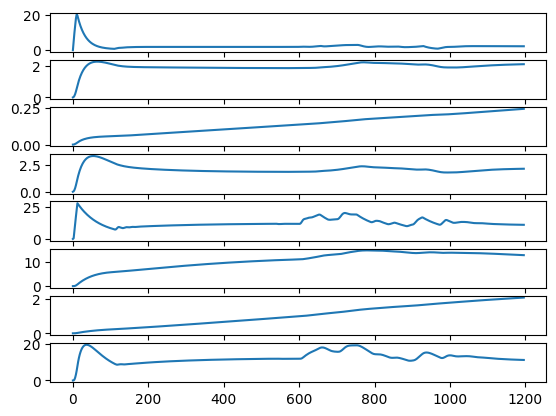

In [4]:
plt.subplot(2, 1, 1)
plt.plot(results['Time'], results['BIS'], label='BIS')
plt.plot(results['Time'], results['BIS']*0 + 50, label='BIS target')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(results['Time'], results['u_propo'], label='propo')
plt.plot(results['Time'], results['u_remi'], label='remi')
plt.legend()
plt.grid()

plt.show()

# plot states
x = results['x'].values
for i in range(8):
    plt.subplot(8, 1, i+1)
    x_i = [x_j[i] for x_j in x]
    plt.plot(results['Time'], x_i, label=f'x{i}')

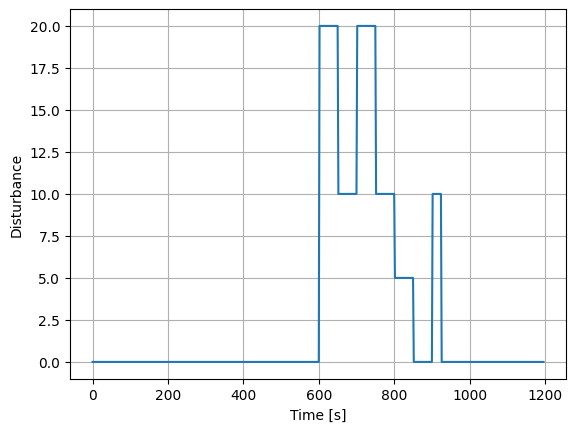

In [5]:
# plot disturbance profil
time = results['Time']
plt.plot(time, custom_disturbance(time)[0])
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Disturbance')
plt.show()